<a href="https://colab.research.google.com/github/JenniEun/pose_extraction_mediapipe/blob/main/pose_extraction_mediapipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting Up Mediapipe version 0.10.31.
Initially I faced an "AttributeError: module 'mediapipe' has no attribute 'solutions'"
1. when the mediapipe version is incompatible, these errors occurs.


In [1]:
!pip install numpy openai opencv-python mediapipe requests Pillow matplotlib
!pip install transformers timm
!pip install torch torchvision torchaudio

import requests
import torch
import cv2
import numpy as np
import openai
import mediapipe as mp
import io
import base64
from PIL import Image
from scipy.spatial import ConvexHull
from torchvision.transforms import Compose

2. Installing Mediapipe version 0.10.31

In [2]:
!pip install mediapipe==0.10.31 opencv-python matplotlib


3. Download the poselandmarker model:
Mediapipe 0.10+ versions  requires a '.task' model file. For pose detection, you can use the full pose landmark model:

Also this is the official changed storage path by google for mediapipe 0.10.x, suitable for google colab and python 3.12


In [3]:
!wget -O pose_landmarker_full.task \
https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/1/pose_landmarker_full.task



--2026-01-27 23:10:14--  https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/1/pose_landmarker_full.task
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9398198 (9.0M) [application/octet-stream]
Saving to: ‘pose_landmarker_full.task’

pose_landmarker_ful 100%[===================>]   8.96M  54.9MB/s    in 0.2s    

2026-01-27 23:10:14 (54.9 MB/s) - ‘pose_landmarker_full.task’ saved [9398198/9398198]



In [4]:
!ls -lh pose_landmarker_full.task


-rw-r--r-- 1 root root 9.0M Apr 28  2023 pose_landmarker_full.task


4. This code cell is primarily setting up the environment by importing all the necessary libraries and modules for performing pose landmark detection using Mediapipe.

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python.vision import (
    PoseLandmarker,
    PoseLandmarkerOptions,
    RunningMode
)



In [7]:
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="pose_landmarker_full.task"),
    running_mode=RunningMode.IMAGE
)

pose_landmarker = PoseLandmarker.create_from_options(options)


In [8]:
from google.colab import files
files.upload()


Saving Pose 1.jpg to Pose 1.jpg


{'Pose 1.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x0f\x12\x15\x16\x15\x10\x15\x15\x10\x10\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x16\x16\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x17\x10\x10\x15-\x1d\x1d\x1d+-7++-+/+-+++----+-..-+---7------+-++-----+-------\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x00\x03\x04\x05\x06\x07\x08\xff\xc4\x00A\x10\x00\x02\x01\x02\x03\x04\x06\x05\t\x06\x07\x01\x00\x00\x00\x00\x00\x01\x02\x03\x11\x04!1\x05\x12AQ\x062aq\x81\x91\x07\x13"\xa1\xd1BRSbr\xa2\xb1\xc1\xd2\x14\x15\x92\xc2\xf0\xf1\x16#3C\x82\xb2\xe1\xa3\xff\xc4\x00\x17\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\xff\xc4\x00#\x11\x01\x01\x00\x02\x02\x02\x02\x01\x05\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11

In [9]:
IMAGE_PATH = "/content/Pose 1.jpg"
MODEL_PATH = "/content/pose_landmarker_full.task"


In [10]:
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mp_image = mp.Image(
    image_format=mp.ImageFormat.SRGB,
    data=image_rgb
)


Note: while importing if you don't use/miss importing:
 *import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision*

you will get a name error python which says the particular import from the mediapipe is not happened.

In [11]:
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)

options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options)


Create Pose Landmarkmarker (fixed API with 33 landmarks )

In [12]:
base_options = python.BaseOptions(
    model_asset_path="/content/pose_landmarker_full.task"
)

options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options)


Detect Landmarks

In [13]:
result = pose_landmarker.detect(mp_image)

print("Number of poses detected:", len(result.pose_landmarks))


Number of poses detected: 1


In [14]:
for i, landmark in enumerate(result.pose_landmarks[0]):
    print(
        f"Landmark {i}: "
        f"x={landmark.x:.3f}, "
        f"y={landmark.y:.3f}, "
        f"z={landmark.z:.3f}, "
        f"visibility={landmark.visibility:.3f}"
    )


Landmark 0: x=0.467, y=0.441, z=-0.196, visibility=1.000
Landmark 1: x=0.473, y=0.427, z=-0.200, visibility=1.000
Landmark 2: x=0.475, y=0.426, z=-0.200, visibility=1.000
Landmark 3: x=0.477, y=0.425, z=-0.200, visibility=1.000
Landmark 4: x=0.469, y=0.426, z=-0.182, visibility=1.000
Landmark 5: x=0.470, y=0.425, z=-0.182, visibility=1.000
Landmark 6: x=0.470, y=0.424, z=-0.182, visibility=1.000
Landmark 7: x=0.491, y=0.427, z=-0.174, visibility=1.000
Landmark 8: x=0.479, y=0.426, z=-0.092, visibility=1.000
Landmark 9: x=0.473, y=0.452, z=-0.184, visibility=1.000
Landmark 10: x=0.468, y=0.452, z=-0.160, visibility=1.000
Landmark 11: x=0.540, y=0.496, z=-0.138, visibility=1.000
Landmark 12: x=0.451, y=0.483, z=-0.052, visibility=1.000
Landmark 13: x=0.612, y=0.491, z=-0.177, visibility=0.999
Landmark 14: x=0.383, y=0.474, z=-0.050, visibility=0.994
Landmark 15: x=0.671, y=0.480, z=-0.241, visibility=0.996
Landmark 16: x=0.324, y=0.454, z=-0.150, visibility=0.993
Landmark 17: x=0.689, y=

Note: Remember we are using mediapipe 0.10.31 version and python 3.12,
if I code for drawing landmarks on the image using "solutions" like this

**mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

annotated_image = image.copy()

mp_drawing.draw_landmarks(
    annotated_image,
    result.pose_landmarks[0],
    mp_pose.POSE_CONNECTIONS
)

cv2.imshow("Pose Landmarks", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()**
then my code will show attibute error telling the module has no specific attribute called solution

Avoid this

Define pose connections (official 33-landmark skeleton)

In [15]:
POSE_CONNECTIONS = [
    (11, 13), (13, 15),   # Left arm
    (12, 14), (14, 16),   # Right arm
    (11, 12),             # Shoulders
    (23, 24),             # Hips
    (11, 23), (12, 24),   # Torso
    (23, 25), (25, 27),   # Left leg
    (24, 26), (26, 28),   # Right leg
    (27, 29), (29, 31),   # Left foot
    (28, 30), (30, 32),   # Right foot
]


Convert normalized landmarks → pixel coordinates

In [16]:
h, w, _ = image.shape

landmarks_px = []
for lm in result.pose_landmarks[0]:
    x_px = int(lm.x * w)
    y_px = int(lm.y * h)
    landmarks_px.append((x_px, y_px))


Draw landmarks (circles)

In [17]:
annotated_image = image.copy()

for (x, y) in landmarks_px:
    cv2.circle(annotated_image, (x, y), 4, (0, 255, 0), -1)


Draw pose skeleton (lines)

In [18]:
for start, end in POSE_CONNECTIONS:
    cv2.line(
        annotated_image,
        landmarks_px[start],
        landmarks_px[end],
        (255, 0, 0),
        2
    )


Display in Colab

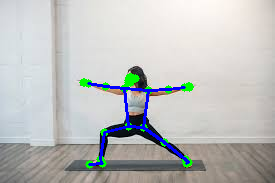

In [19]:
from google.colab.patches import cv2_imshow
cv2_imshow(annotated_image)


Next step if i just want to visualise the pose what should I do?

Create a blank canvas (same size as image)

In [20]:
h, w, _ = image.shape
blank = np.zeros((h, w, 3), dtype=np.uint8)


Draw ONLY landmarks (no image)

In [21]:
for (x, y) in landmarks_px:
    cv2.circle(blank, (x, y), 4, (0, 255, 0), -1)


Draw ONLY skeleton connections

In [22]:
for start, end in POSE_CONNECTIONS:
    cv2.line(
        blank,
        landmarks_px[start],
        landmarks_px[end],
        (255, 255, 255),
        2
    )


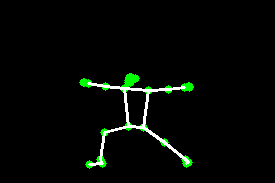

In [23]:
from google.colab.patches import cv2_imshow
cv2_imshow(blank)


Next step suppose i have a couple of images how to extract pose landmarks?
Step 1: Create a structured folder

In [24]:
import os

BASE_DIR = "/content"
IMAGE_DIR = os.path.join(BASE_DIR, "pose_images")
POSE_IMG_DIR = os.path.join(BASE_DIR, "pose_only_images")
CSV_DIR = os.path.join(BASE_DIR, "pose_csv")

os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(POSE_IMG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

print("Folders created successfully")


Folders created successfully


In [26]:
!ls /content


'Pose 1 (1).jpg'  'pose 3.jpg'	 pose_images		     sample_data
'Pose 1.jpg'	  'Pose 4.jpg'	 pose_landmarker_full.task
'Pose 2.jpg'	   pose_csv	 pose_only_images


In [25]:
from google.colab import files
files.upload()


Saving Pose 1.jpg to Pose 1 (1).jpg
Saving Pose 2.jpg to Pose 2.jpg
Saving pose 3.jpg to pose 3.jpg
Saving Pose 4.jpg to Pose 4.jpg


{'Pose 1 (1).jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x0f\x12\x15\x16\x15\x10\x15\x15\x10\x10\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x16\x16\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x17\x10\x10\x15-\x1d\x1d\x1d+-7++-+/+-+++----+-..-+---7------+-++-----+-------\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x00\x03\x04\x05\x06\x07\x08\xff\xc4\x00A\x10\x00\x02\x01\x02\x03\x04\x06\x05\t\x06\x07\x01\x00\x00\x00\x00\x00\x01\x02\x03\x11\x04!1\x05\x12AQ\x062aq\x81\x91\x07\x13"\xa1\xd1BRSbr\xa2\xb1\xc1\xd2\x14\x15\x92\xc2\xf0\xf1\x16#3C\x82\xb2\xe1\xa3\xff\xc4\x00\x17\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\xff\xc4\x00#\x11\x01\x01\x00\x02\x02\x02\x02\x01\x05\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02

In [27]:
!mv *.jpg /content/pose_images/


In [28]:
import os
import csv
import cv2
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [29]:
BASE_DIR = "/content"
IMAGE_DIR = os.path.join(BASE_DIR, "pose_images")
POSE_IMG_DIR = os.path.join(BASE_DIR, "pose_only_images")
CSV_DIR = os.path.join(BASE_DIR, "pose_csv")

MODEL_PATH = "/content/pose_landmarker_full.task"

os.makedirs(POSE_IMG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)


In [30]:
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)

options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options)


In [31]:
POSE_CONNECTIONS = [
    (11,13),(13,15),(12,14),(14,16),
    (11,12),(23,24),(11,23),(12,24),
    (23,25),(25,27),(24,26),(26,28),
    (27,29),(29,31),(28,30),(30,32)
]


In [32]:
csv_path = os.path.join(CSV_DIR, "pose_landmarks.csv")

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)

    header = []
    for i in range(33):
        header += [f"x_{i}", f"y_{i}", f"z_{i}", f"vis_{i}"]
    writer.writerow(header)

    for img_name in sorted(os.listdir(IMAGE_DIR)):
        if not img_name.lower().endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(IMAGE_DIR, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"❌ Cannot read {img_name}")
            continue

        h, w, _ = image.shape
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=image_rgb
        )

        result = pose_landmarker.detect(mp_image)

        if not result.pose_landmarks:
            print(f"⚠️ No pose detected in {img_name}")
            continue

        blank = np.zeros((h, w, 3), dtype=np.uint8)

        row = []
        landmarks_px = []

        for lm in result.pose_landmarks[0]:
            x_px = int(lm.x * w)
            y_px = int(lm.y * h)
            landmarks_px.append((x_px, y_px))

            row.extend([lm.x, lm.y, lm.z, lm.visibility])

            cv2.circle(blank, (x_px, y_px), 4, (255,255,255), -1)

        for s, e in POSE_CONNECTIONS:
            cv2.line(blank, landmarks_px[s], landmarks_px[e], (255,255,255), 2)

        writer.writerow(row)

        out_path = os.path.join(POSE_IMG_DIR, img_name)
        cv2.imwrite(out_path, blank)

        print(f"✅ Processed {img_name}")

print("🎉 All images processed successfully")
print("📄 CSV:", csv_path)
print("🖼 Pose images:", POSE_IMG_DIR)


✅ Processed Pose 1 (1).jpg
✅ Processed Pose 1.jpg
✅ Processed Pose 2.jpg
✅ Processed Pose 4.jpg
✅ Processed pose 3.jpg
🎉 All images processed successfully
📄 CSV: /content/pose_csv/pose_landmarks.csv
🖼 Pose images: /content/pose_only_images


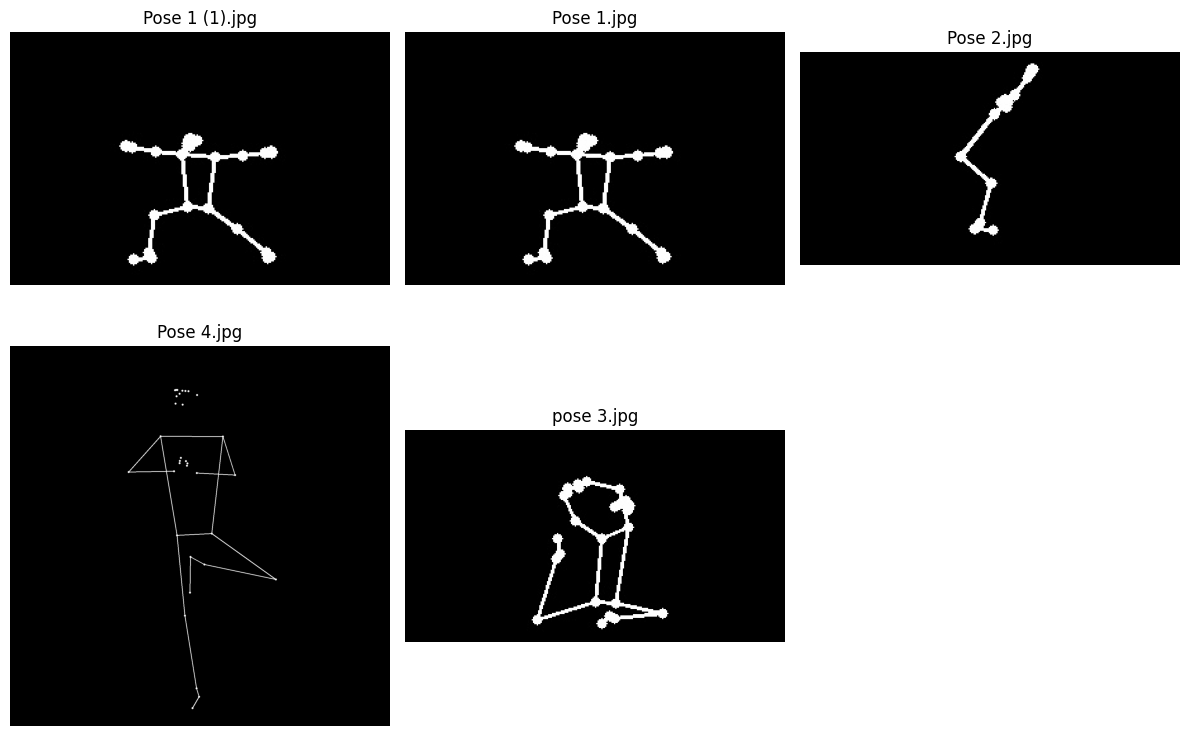

In [33]:
import matplotlib.pyplot as plt

images = []
titles = []

for img_name in sorted(os.listdir("/content/pose_only_images")):
    if img_name.lower().endswith((".jpg", ".png")):
        img = cv2.imread(f"/content/pose_only_images/{img_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(img_name)

cols = 3
rows = (len(images) + cols - 1) // cols

plt.figure(figsize=(12, 4 * rows))
for i, img in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [34]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jenniferandrew","key":"045384342ec807daff75d41ad2733f9f"}'}

In [35]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [36]:
!kaggle datasets list


ref                                                                title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                                Chocolate Sales                                      468320  2026-01-04 14:23:35.490000              0        120  1.0              
vishardmehta/indian-engineering-college-placement-dataset          Indian Engineering College Placement Dataset         137603  2026-01-24 15:23:40.150000              0         26  1.0              
rockyt07/social-media-user-analysis                                Social Media User Analysis                        247842357  2026-01-14 02:28:41.970000              0        122  1.0              


In [37]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip


Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [38]:
!ls asl_alphabet_train


asl_alphabet_train


In [39]:
# asl-alphabet
# asl_alphabet_train
# asl_alphabet_test

In [40]:
import os
import cv2

data_path = "asl_alphabet_train/asl_alphabet_train"
images = []
labels = []

for label in os.listdir(data_path):
    label_path = os.path.join(data_path, label)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)

print(len(images), "images loaded")


87000 images loaded


In [41]:
!ls


asl_alphabet_test   kaggle.json  pose_landmarker_full.task
asl_alphabet_train  pose_csv	 pose_only_images
asl-alphabet.zip    pose_images  sample_data


In [42]:
!ls asl_alphabet_train | head


asl_alphabet_train


In [43]:
!ls asl_alphabet_train/asl_alphabet_train/A | head


A1000.jpg
A1001.jpg
A1002.jpg
A1003.jpg
A1004.jpg
A1005.jpg
A1006.jpg
A1007.jpg
A1008.jpg
A1009.jpg


In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python.vision import (
    PoseLandmarker,
    PoseLandmarkerOptions,
    RunningMode
)



In [45]:
import cv2
import numpy as np
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Re-initialize the pose detector using the new API and model
# Assuming MODEL_PATH is defined in the environment or notebook
# If not, you might need to define it explicitly, e.g., MODEL_PATH = "/content/pose_landmarker_full.task"

# Ensure MODEL_PATH is accessible, it was defined in a previous cell
MODEL_PATH = "/content/pose_landmarker_full.task"

base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

def get_pose_landmarks(img_path):
    """
    Takes an image path, returns pose landmarks as a NumPy array (33x4)
    or None if no landmarks detected.
    """
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image not found: {img_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

    detection_result = pose_landmarker.detect(mp_image)

    if detection_result.pose_landmarks:
        landmarks = np.array([[lm.x, lm.y, lm.z, lm.visibility]
                              for lm in detection_result.pose_landmarks[0]])
        return landmarks
    else:
        return None


In [46]:
folder_path = "/content/asl_alphabet_train/asl_alphabet_train/A"
output_folder = "/content/pose_landmarks/A"
os.makedirs(output_folder, exist_ok=True)

for img_file in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_file)
    landmarks = get_pose_landmarks(img_path)
    if landmarks is not None:
        save_path = os.path.join(output_folder, img_file.replace(".jpg", "_pose.npy"))
        np.save(save_path, landmarks)

In [47]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt

# Model path, assuming it's available from previous steps
MODEL_PATH = "/content/pose_landmarker_full.task"

# Initialize PoseLandmarker
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE, # Changed to IMAGE mode for static images
    output_segmentation_masks=False
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

# Define pose connections (official 33-landmark skeleton)
POSE_CONNECTIONS = [
    (11, 13), (13, 15),   # Left arm
    (12, 14), (14, 16),   # Right arm
    (11, 12),             # Shoulders
    (23, 24),             # Hips
    (11, 23), (12, 24),   # Torso
    (23, 25), (25, 27),   # Left leg
    (24, 26), (26, 28),   # Right leg
    (27, 29), (29, 31),   # Left foot
    (28, 30), (30, 32)    # Right foot
]

def show_pose_landmarks(img_path):
    """
    Processes an image, draws pose landmarks, and shows the image.
    """
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image not found: {img_path}")
        return

    h, w, _ = image.shape
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

    detection_result = pose_landmarker.detect(mp_image)

    annotated_image = image.copy()
    if detection_result.pose_landmarks:
        landmarks_px = []
        for lm in detection_result.pose_landmarks[0]:
            x_px = int(lm.x * w)
            y_px = int(lm.y * h)
            landmarks_px.append((x_px, y_px))
            # Draw landmarks (circles)
            cv2.circle(annotated_image, (x_px, y_px), 4, (0, 255, 0), -1)

        # Draw pose skeleton (lines)
        for start, end in POSE_CONNECTIONS:
            cv2.line(
                annotated_image,
                landmarks_px[start],
                landmarks_px[end],
                (255, 0, 0),
                2
            )
        print("Pose landmarks detected!")
    else:
        print("No pose landmarks detected.")

    # Convert BGR to RGB for displaying in Colab
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Display using matplotlib (works in Colab)
    plt.figure(figsize=(6,6))
    plt.imshow(annotated_image_rgb)
    plt.title(f"Pose Landmarks for {img_path.split('/')[-1]}")
    plt.axis('off')
    plt.show()


Pose landmarks detected!


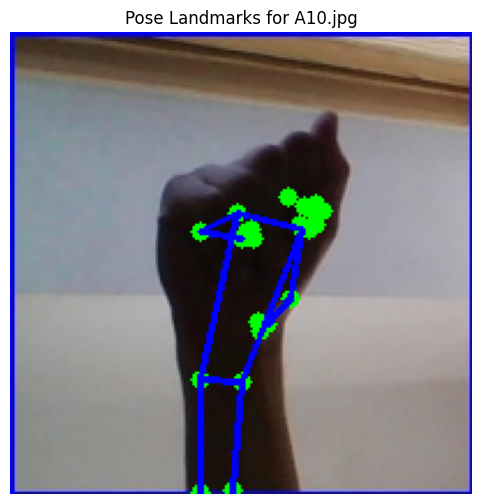

In [48]:
img_path = "/content/asl_alphabet_train/asl_alphabet_train/A/A10.jpg"
show_pose_landmarks(img_path)


In [49]:
!pip install -U mediapipe opencv-python


  Using cached mediapipe-0.10.32-py3-none-manylinux_2_28_x86_64.whl.metadata (9.8 kB)
Using cached mediapipe-0.10.32-py3-none-manylinux_2_28_x86_64.whl (10.3 MB)
  Attempting uninstall: mediapipe
    Found existing installation: mediapipe 0.10.31
    Uninstalling mediapipe-0.10.31:
      Successfully uninstalled mediapipe-0.10.31


In [50]:
import os
import csv
import cv2
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [51]:
BASE_DIR = "/content"

TRAIN_DIR = os.path.join(BASE_DIR, "asl_alphabet_train")
TEST_DIR  = os.path.join(BASE_DIR, "asl_alphabet_test")

OUT_IMG_DIR = os.path.join(BASE_DIR, "hand_landmark_images")
OUT_NPY_DIR = os.path.join(BASE_DIR, "hand_landmarks_npy")

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_NPY_DIR, exist_ok=True)


In [52]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


In [53]:
base_options = python.BaseOptions(
    model_asset_path="hand_landmarker.task"
)

options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1
)

hand_landmarker = vision.HandLandmarker.create_from_options(options)


In [54]:
def process_image(image_path, save_name):
    image = cv2.imread(image_path)
    if image is None:
        return

    h, w, _ = image.shape
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
    result = hand_landmarker.detect(mp_image)

    if not result.hand_landmarks:
        return

    # Take first detected hand
    landmarks = result.hand_landmarks[0]

    # ---- Save landmarks ----
    lm_array = np.array([[lm.x, lm.y, lm.z] for lm in landmarks])
    np.save(os.path.join(OUT_NPY_DIR, save_name + ".npy"), lm_array)

    # ---- Draw ONLY landmarks (no background) ----
    blank = np.zeros((h, w, 3), dtype=np.uint8)

    for lm in landmarks:
        cx, cy = int(lm.x * w), int(lm.y * h)
        cv2.circle(blank, (cx, cy), 4, (0, 255, 0), -1)

    cv2.imwrite(os.path.join(OUT_IMG_DIR, save_name + ".jpg"), blank)


In [55]:
def run_on_dataset(dataset_dir):
    for label in sorted(os.listdir(dataset_dir)):
        label_path = os.path.join(dataset_dir, label)

        if not os.path.isdir(label_path):
            continue

        for img_name in os.listdir(label_path):
            if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                continue

            img_path = os.path.join(label_path, img_name)
            save_name = f"{label}_{os.path.splitext(img_name)[0]}"

            process_image(img_path, save_name)

run_on_dataset(TRAIN_DIR)
run_on_dataset(TEST_DIR)


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

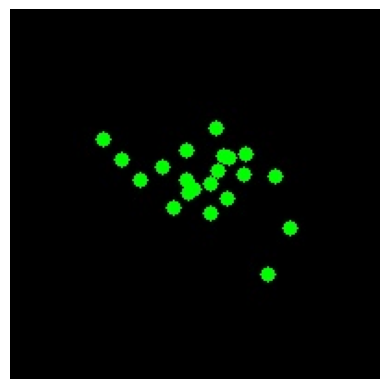

In [56]:
import matplotlib.pyplot as plt

sample = os.listdir(OUT_IMG_DIR)[0]
img = cv2.imread(os.path.join(OUT_IMG_DIR, sample))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")


In [57]:
DATASET_DIR = "/content/asl_alphabet_train/asl_alphabet_train"   # your ASL dataset
OUT_IMG_DIR = "/content/ASL_landmarks"

os.makedirs(OUT_IMG_DIR, exist_ok=True)


In [58]:
!wget -O /content/hand_landmarker.task \
https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


--2026-01-27 23:23:19--  https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.163.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.163.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7819105 (7.5M) [application/octet-stream]
Saving to: ‘/content/hand_landmarker.task’

/content/hand_landm 100%[===================>]   7.46M  --.-KB/s    in 0.06s   

2026-01-27 23:23:19 (133 MB/s) - ‘/content/hand_landmarker.task’ saved [7819105/7819105]



In [59]:
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20)
]


In [60]:
def draw_hand_skeleton(canvas, landmarks, w, h):
    # draw connections
    for s, e in HAND_CONNECTIONS:
        x1, y1 = int(landmarks[s].x * w), int(landmarks[s].y * h)
        x2, y2 = int(landmarks[e].x * w), int(landmarks[e].y * h)
        cv2.line(canvas, (x1,y1), (x2,y2), (0,255,0), 3)

    # draw joints
    for lm in landmarks:
        cx, cy = int(lm.x * w), int(lm.y * h)
        cv2.circle(canvas, (cx, cy), 5, (0,0,255), -1)


In [61]:
from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions # Directly import BaseOptions

base_options = BaseOptions(
    model_asset_path="/content/hand_landmarker.task"
)

options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1
)

detector = vision.HandLandmarker.create_from_options(options)

In [63]:
actual_data_root = DATASET_DIR
processed_count = 0
found_hands_count = 0

for label in os.listdir(actual_data_root):
    label_dir_path = os.path.join(actual_data_root, label)
    if not os.path.isdir(label_dir_path):
        continue

    os.makedirs(os.path.join(OUT_IMG_DIR, label), exist_ok=True)

    print(f"Processing label: {label}")
    for fname in os.listdir(label_dir_path):
        if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(label_dir_path, fname)
        processed_count += 1

        img = cv2.imread(img_path)
        if img is None:
            print(f"  ⚠️ Could not read image: {fname}")
            continue

        h, w, _ = img.shape

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=img
        )

        result = detector.detect(mp_image)
        if not result.hand_landmarks:
            # print(f"  No hand landmarks detected for: {fname}") # Too verbose
            continue

        found_hands_count += 1
        landmarks = result.hand_landmarks[0]

        blank = np.zeros((h, w, 3), dtype=np.uint8)
        draw_hand_skeleton(blank, landmarks, w, h)

        out_path = os.path.join(OUT_IMG_DIR, label, fname)
        cv2.imwrite(out_path, blank)

print(f"\n--- Summary ---")
print(f"Total images iterated: {processed_count}")
print(f"Images with detected hands: {found_hands_count}")
print(f"Output directory: {OUT_IMG_DIR}")

Processing label: L
Processing label: M
Processing label: G
Processing label: A
Processing label: R
Processing label: U
Processing label: H
Processing label: N
Processing label: T
Processing label: I
Processing label: W
Processing label: S
Processing label: del
Processing label: J
Processing label: O
Processing label: Z
Processing label: V
Processing label: X
Processing label: Y
Processing label: E
Processing label: D
Processing label: P
Processing label: K
Processing label: Q
Processing label: C
Processing label: space
Processing label: B
Processing label: F
Processing label: nothing

--- Summary ---
Total images iterated: 87000
Images with detected hands: 15770
Output directory: /content/ASL_landmarks


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

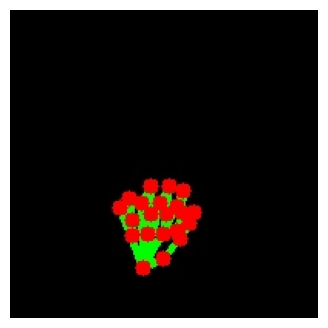

In [65]:
sample_label = os.listdir(OUT_IMG_DIR)[0]
sample_img = os.listdir(os.path.join(OUT_IMG_DIR, sample_label))[0]

img = cv2.imread(os.path.join(OUT_IMG_DIR, sample_label, sample_img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")


Generating ASL_landmarks CSV file


In [67]:
import os
import numpy as np
import pandas as pd

data_dir = "/content/ASL_landmarks"  # your folder
classes = sorted(os.listdir(data_dir))
rows = []

for cls in classes:
    cls_folder = os.path.join(data_dir, cls)
    for file in os.listdir(cls_folder):
        if file.endswith(".npy"):
            file_path = os.path.join(cls_folder, file)
            landmarks = np.load(file_path)  # shape (21,3)
            flat_landmarks = landmarks.flatten()
            row = list(flat_landmarks) + [cls]  # add class label at the end
            rows.append(row)

# Create column names
cols = []
for i in range(21):
    cols.extend([f"x{i+1}", f"y{i+1}", f"z{i+1}"])
cols.append("label")  # last column

# Create DataFrame
df = pd.DataFrame(rows, columns=cols)

# Save to CSV
csv_path = "/content/ASL_landmarks.csv"
df.to_csv(csv_path, index=False)
print("CSV file saved at:", csv_path)


CSV file saved at: /content/ASL_landmarks.csv


In [68]:
print(f"All extracted landmark JPEG images are saved in: {OUT_IMG_DIR}")
!ls {OUT_IMG_DIR}

All extracted landmark JPEG images are saved in: /content/ASL_landmarks
A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


Similarly we need to prepare Test datasets landmarks


In [69]:
DATASET_DIR = "/content/asl_alphabet_test/asl_alphabet_test"   # your ASL dataset
OUT_IMG_DIR = "/content/ASL_test_landmarks"

os.makedirs(OUT_IMG_DIR, exist_ok=True)


In [70]:
!wget -O /content/hand_landmarker.task \
https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


--2026-01-28 00:13:43--  https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7819105 (7.5M) [application/octet-stream]
Saving to: ‘/content/hand_landmarker.task’

/content/hand_landm 100%[===================>]   7.46M  --.-KB/s    in 0.03s   

2026-01-28 00:13:43 (289 MB/s) - ‘/content/hand_landmarker.task’ saved [7819105/7819105]



In [71]:
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20)
]


In [72]:
def draw_hand_skeleton(canvas, landmarks, w, h):
    # draw connections
    for s, e in HAND_CONNECTIONS:
        x1, y1 = int(landmarks[s].x * w), int(landmarks[s].y * h)
        x2, y2 = int(landmarks[e].x * w), int(landmarks[e].y * h)
        cv2.line(canvas, (x1,y1), (x2,y2), (0,255,0), 3)

    # draw joints
    for lm in landmarks:
        cx, cy = int(lm.x * w), int(lm.y * h)
        cv2.circle(canvas, (cx, cy), 5, (0,0,255), -1)


In [73]:
from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions # Directly import BaseOptions

base_options = BaseOptions(
    model_asset_path="/content/hand_landmarker.task"
)

options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1
)

detector = vision.HandLandmarker.create_from_options(options)